In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
from pathlib import Path
import pandas as pd
import spacy
# Add project root to Python path (go up one level from notebooks/)
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))
from main import load_config

c:\Users\Besitzer\OneDrive\Dokumente\CBS_Copenhagen\Semester\WS2025\AdvCV\Final Exam\AVDNLP_final_project\venv\Lib\site-packages\pydantic\_internal\_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
c:\Users\Besitzer\OneDrive\Dokumente\CBS_Copenhagen\Semester\WS2025\AdvCV\Final Exam\AVDNLP_final_project\venv\Lib\site-packages\pydantic\_internal\_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-sp

In [4]:
config = load_config("configs/config.yaml")
model_name_destileldBert = 'distilbert-base-uncased'
model_name_bert = 'bert-base-uncased'


Loaded config from c:\Users\Besitzer\OneDrive\Dokumente\CBS_Copenhagen\Semester\WS2025\AdvCV\Final Exam\AVDNLP_final_project\configs\config.yaml


In [5]:
# ...existing code...
from pathlib import Path
import os

def find_project_root(start: Path = None, markers=(".git", "pyproject.toml", "setup.py")) -> Path:
    start = Path(start or Path.cwd()).resolve()
    for p in [start] + list(start.parents):
        if any((p / m).exists() for m in markers):
            return p
    return Path.cwd()

# Prefer explicit env var for cloud runs; otherwise try __file__ then cwd then repo-root
project_root = None
if "PROJECT_ROOT" in os.environ:
    project_root = Path(os.environ["PROJECT_ROOT"]).resolve()
else:
    try:
        # works in scripts, not in notebooks
        project_root = Path(__file__).parent.resolve()
    except NameError:
        # notebook / interactive fallback: try repo root then cwd
        project_root = find_project_root()

# build paths relative to project_root
notebooks_dir = project_root / "notebooks"
mis_dir = notebooks_dir / "misclassifications"

bert_path = mis_dir / "misclassifications_Stanford_bert_partial_finetune.csv"
bert_lora_path = mis_dir / "misclassifications_Stanford_bert_lora_r8.csv"
distilled_bert_path = mis_dir / "misclassifications_Stanford_distilbert_lora_r8.csv"
distilled_bert_lora_path = mis_dir / "misclassifications_Stanford_distilbert_partial_finetune.csv"

print("Using project_root:", project_root)

Using project_root: C:\Users\Besitzer\OneDrive\Dokumente\CBS_Copenhagen\Semester\WS2025\AdvCV\Final Exam\AVDNLP_final_project


In [6]:
# ...existing code...
from pathlib import Path

def find_file(name, start=project_root):
    start = Path(start or Path.cwd()).resolve()
    return list(start.rglob(name))

print("project_root:", project_root)
print("mis_dir:", mis_dir)
print("expected bert_path:", bert_path)
print("bert_path.exists():", bert_path.exists())

if not bert_path.exists():
    print("Searching repo for misclassifications_Stanford_bert_partial_finetune.csv ...")
    found = find_file("misclassifications_Stanford_bert_partial_finetune.csv", project_root)
    if not found:
        raise FileNotFoundError(f"Could not locate misclassifications_Stanford_bert_partial_finetune.csv under {project_root}")
    bert_path = found[0]
    print("Found bert_path at:", bert_path)

# helper to load or search
def load_or_search(p: Path):
    if isinstance(p, str):
        p = Path(p)
    if p.exists():
        return pd.read_csv(p)
    found = find_file(p.name, project_root)
    if not found:
        raise FileNotFoundError(f"Could not locate {p.name} under {project_root}")
    print(f"Loading {p.name} from {found[0]}")
    return pd.read_csv(found[0])

df_bert = load_or_search(bert_path)
df_bert_lora = load_or_search(bert_lora_path)
df_distilled_bert = load_or_search(distilled_bert_path)
df_distilled_bert_lora = load_or_search(distilled_bert_lora_path)

print("Loaded dataframes:", { 'bert': len(df_bert), 'bert_lora': len(df_bert_lora),
                             'distilled': len(df_distilled_bert), 'distilled_lora': len(df_distilled_bert_lora) })
# ...existing code...

project_root: C:\Users\Besitzer\OneDrive\Dokumente\CBS_Copenhagen\Semester\WS2025\AdvCV\Final Exam\AVDNLP_final_project
mis_dir: C:\Users\Besitzer\OneDrive\Dokumente\CBS_Copenhagen\Semester\WS2025\AdvCV\Final Exam\AVDNLP_final_project\notebooks\misclassifications
expected bert_path: C:\Users\Besitzer\OneDrive\Dokumente\CBS_Copenhagen\Semester\WS2025\AdvCV\Final Exam\AVDNLP_final_project\notebooks\misclassifications\misclassifications_Stanford_bert_partial_finetune.csv
bert_path.exists(): False
Searching repo for misclassifications_Stanford_bert_partial_finetune.csv ...
Found bert_path at: C:\Users\Besitzer\OneDrive\Dokumente\CBS_Copenhagen\Semester\WS2025\AdvCV\Final Exam\AVDNLP_final_project\misclassifications\misclassifications_Stanford_bert_partial_finetune.csv
Loading misclassifications_Stanford_bert_lora_r8.csv from C:\Users\Besitzer\OneDrive\Dokumente\CBS_Copenhagen\Semester\WS2025\AdvCV\Final Exam\AVDNLP_final_project\misclassifications\misclassifications_Stanford_bert_lora_r8.c

In [7]:
# 1) Inspect dataframes to detect text / gold / prediction columns and miscounts
def infer_cols(df):
    cols = [c for c in df.columns.tolist()]
    text_col = next((c for c in cols if 'text' in c.lower() or 'sentence' in c.lower() or 'tweet' in c.lower()), None)
    true_col = next((c for c in cols if c.lower() in ['label','labels','gold','true_label','target','y_true','y']), None)
    pred_col = next((c for c in cols if 'pred' in c.lower() or 'prediction' in c.lower() or 'predicted' in c.lower()), None)
    # fallback heuristics
    if text_col is None:
        text_col = next((c for c in cols if df[c].dtype == object and df[c].str.len().mean() > 10), None)
    return text_col, true_col, pred_col

frames = {'bert': df_bert, 'bert_lora': df_bert_lora, 'distilled': df_distilled_bert, 'distilled_lora': df_distilled_bert_lora}
colinfo = {}
for name, df in frames.items():
    t, y, p = infer_cols(df)
    miscount = None
    if y and p:
        miscount = int((df[y] != df[p]).sum())
    print(f"{name}: rows={len(df)} text_col={t} true_col={y} pred_col={p} misclassified={miscount}")
    colinfo[name] = (t, y, p)

bert: rows=14078 text_col=text true_col=true_label pred_col=predicted_label misclassified=14078
bert_lora: rows=16076 text_col=text true_col=true_label pred_col=predicted_label misclassified=16076
distilled: rows=18512 text_col=text true_col=true_label pred_col=predicted_label misclassified=18512
distilled_lora: rows=17063 text_col=text true_col=true_label pred_col=predicted_label misclassified=17063


In [8]:
import spacy
print(spacy.__version__)

3.8.11


In [9]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.1/12.8 MB 812.7 kB/s eta 0:00:16
     - -------------------------------------- 0.6/12.8 MB 4.6 MB/s eta 0:00:03
     --- ------------------------------------ 1.2/12.8 MB 6.8 MB/s eta 0:00:02
     ----- ---------------------------------- 1.6/12.8 MB 7.4 MB/s eta 0:00:02
     ------- -------------------------------- 2.6/12.8 MB 9.0 MB/s eta 0:00:02
     -------- ------------------------------- 2.8/12.8 MB 9.1 MB/s eta 0:00:02
     ----------- ---------------------------- 3.6/12.8 MB 9.9 MB/s eta 0:00:01
     ------------- -------------------------- 4.3/12.8 MB 10.9 MB/s eta 0:00:01
     -------------- ------------------------- 4.8/12.8 MB 10.8 MB/s eta 0:00:01
     ---------------- ----------------------- 5.3/12.8 MB 10.9 MB/s eta 0:00:01
     ------------------ --------------------- 5.9/12.8 MB 10.7


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [10]:
nlp = spacy.load("en_core_web_sm")

In [11]:
# 3) Feature extraction focusing on sentence structure and syntax
import string
from collections import Counter

def syntax_features(text):
    doc = nlp(text if isinstance(text, str) else '')
    tok_texts = [t.text for t in doc]
    tokens = [t for t in doc]
    char_len = len(text) if text else 0
    token_count = len(tokens)
    avg_token_len = np.mean([len(t.text) for t in tokens]) if tokens else 0
    punct_count = sum(1 for ch in text if ch in string.punctuation)
    comma_count = text.count(',') if text else 0
    uppercase_ratio = np.mean([1 if (t.text.isupper() and t.text.isalpha()) else 0 for t in tokens]) if tokens else 0
    digit_ratio = np.mean([1 if any(ch.isdigit() for ch in t.text) else 0 for t in tokens]) if tokens else 0
    negations = sum(1 for t in tokens if t.dep_ == 'neg' or t.lemma_.lower() in {'not','no','never'})
    ner_count = len(doc.ents)
    # approximate clause count by counting certain dependency labels
    clause_deps = {'advcl','ccomp','xcomp','acl','relcl'}
    clause_count = sum(1 for t in tokens if t.dep_ in clause_deps)
    # tree depth: maximum ancestor chain length
    def token_depth(tok):
        depth = 0
        cur = tok
        while cur.head is not cur:
            depth += 1
            cur = cur.head
            if depth > 200:
                break
        return depth
    depth_vals = [token_depth(t) for t in tokens] if tokens else [0]
    max_depth = int(max(depth_vals)) if depth_vals else 0
    # POS distribution (top 5 tags)
    pos_counts = Counter([t.pos_ for t in tokens])
    pos_top = dict(pos_counts.most_common(5))
    return {
        'char_len': char_len,
        'token_count': token_count,
        'avg_token_len': float(avg_token_len),
        'punct_count': punct_count,
        'comma_count': comma_count,
        'uppercase_ratio': float(uppercase_ratio),
        'digit_ratio': float(digit_ratio),
        'negation_count': negations,
        'ner_count': ner_count,
        'clause_count': int(clause_count),
        'max_dep_depth': int(max_depth),
        'pos_top': pos_top
    }

def annotate_df(df, text_col, true_col, pred_col, max_rows=None):
    sub = df if max_rows is None else df.head(max_rows).copy()
    sub = sub.copy()
    sub['is_mis'] = False if (true_col is None or pred_col is None) else (sub[true_col] != sub[pred_col])
    feats = []
    for i, txt in enumerate(sub[text_col].fillna('').astype(str)):
        feats.append(syntax_features(txt))
    feats_df = pd.DataFrame(feats)
    # expand pos_top keys into columns (sparse)
    pos_df = feats_df['pos_top'].apply(lambda d: pd.Series(d)).fillna(0).astype(int)
    feats_df = pd.concat([feats_df.drop(columns=['pos_top']), pos_df], axis=1)
    res = pd.concat([sub.reset_index(drop=True), feats_df.reset_index(drop=True)], axis=1)
    return res

Annotating bert (this may take a bit) - using columns text=text true=true_label pred=predicted_label
Annotated bert: 2000 rows
Annotating bert_lora (this may take a bit) - using columns text=text true=true_label pred=predicted_label
Annotated bert_lora: 2000 rows
Annotating distilled (this may take a bit) - using columns text=text true=true_label pred=predicted_label
Annotated distilled: 2000 rows
Annotating distilled_lora (this may take a bit) - using columns text=text true=true_label pred=predicted_label
Annotated distilled_lora: 2000 rows

Model: bert


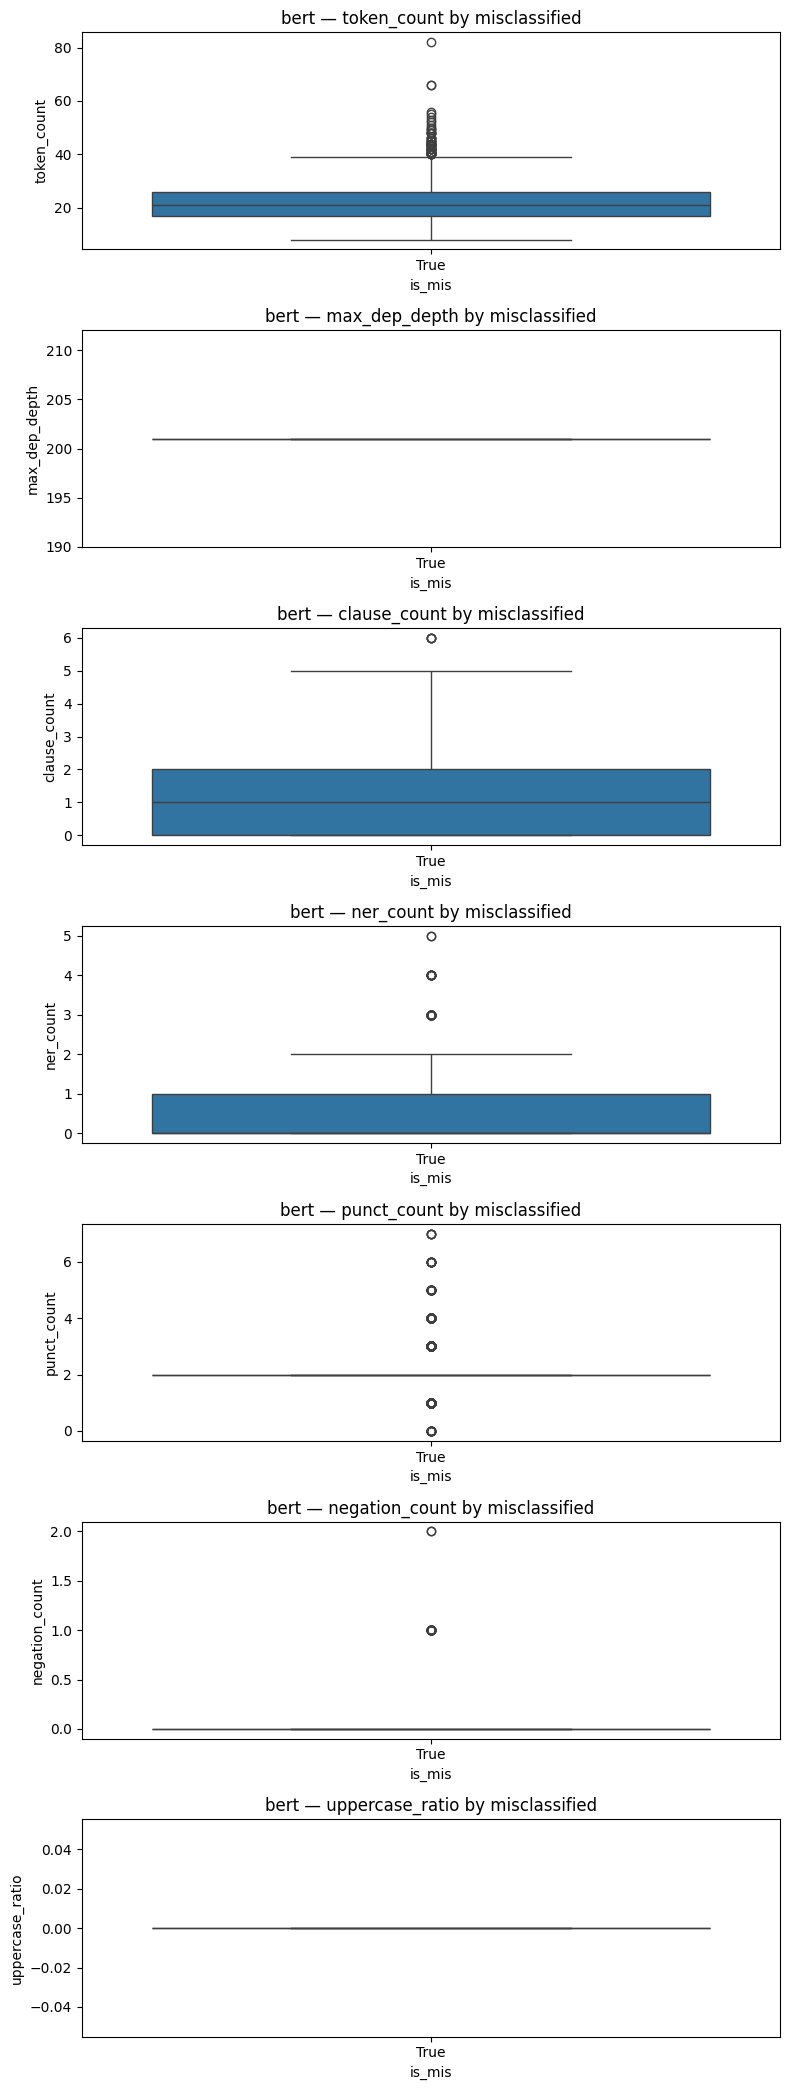


Model: bert_lora


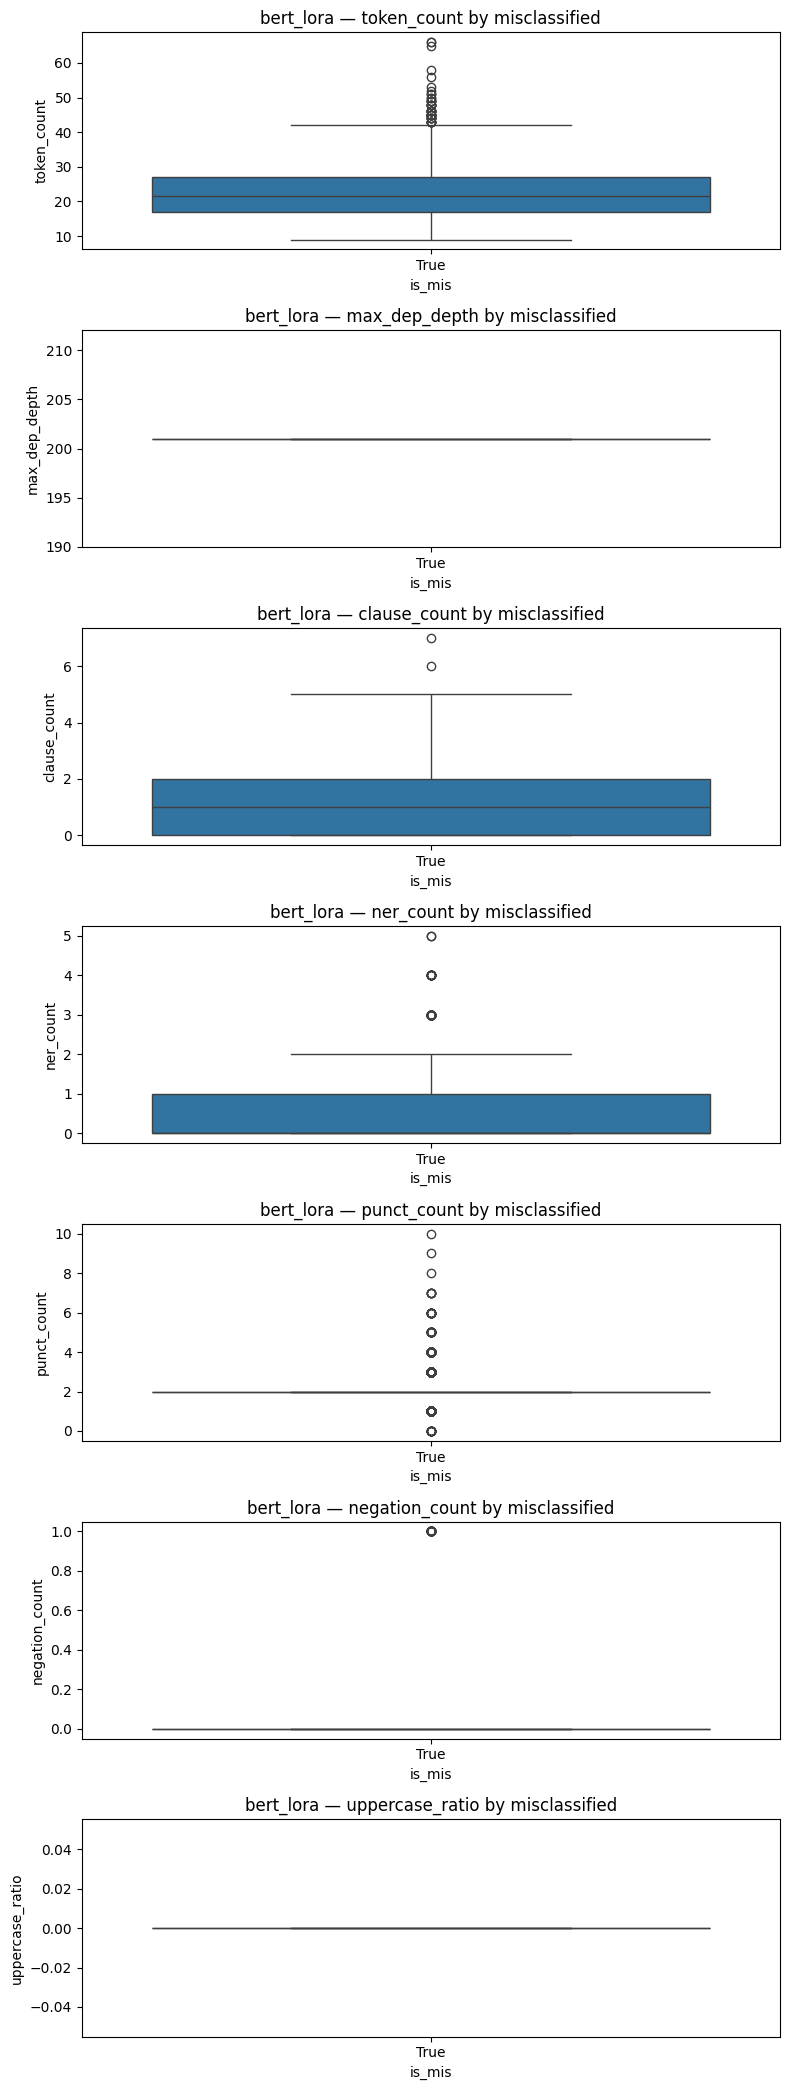


Model: distilled


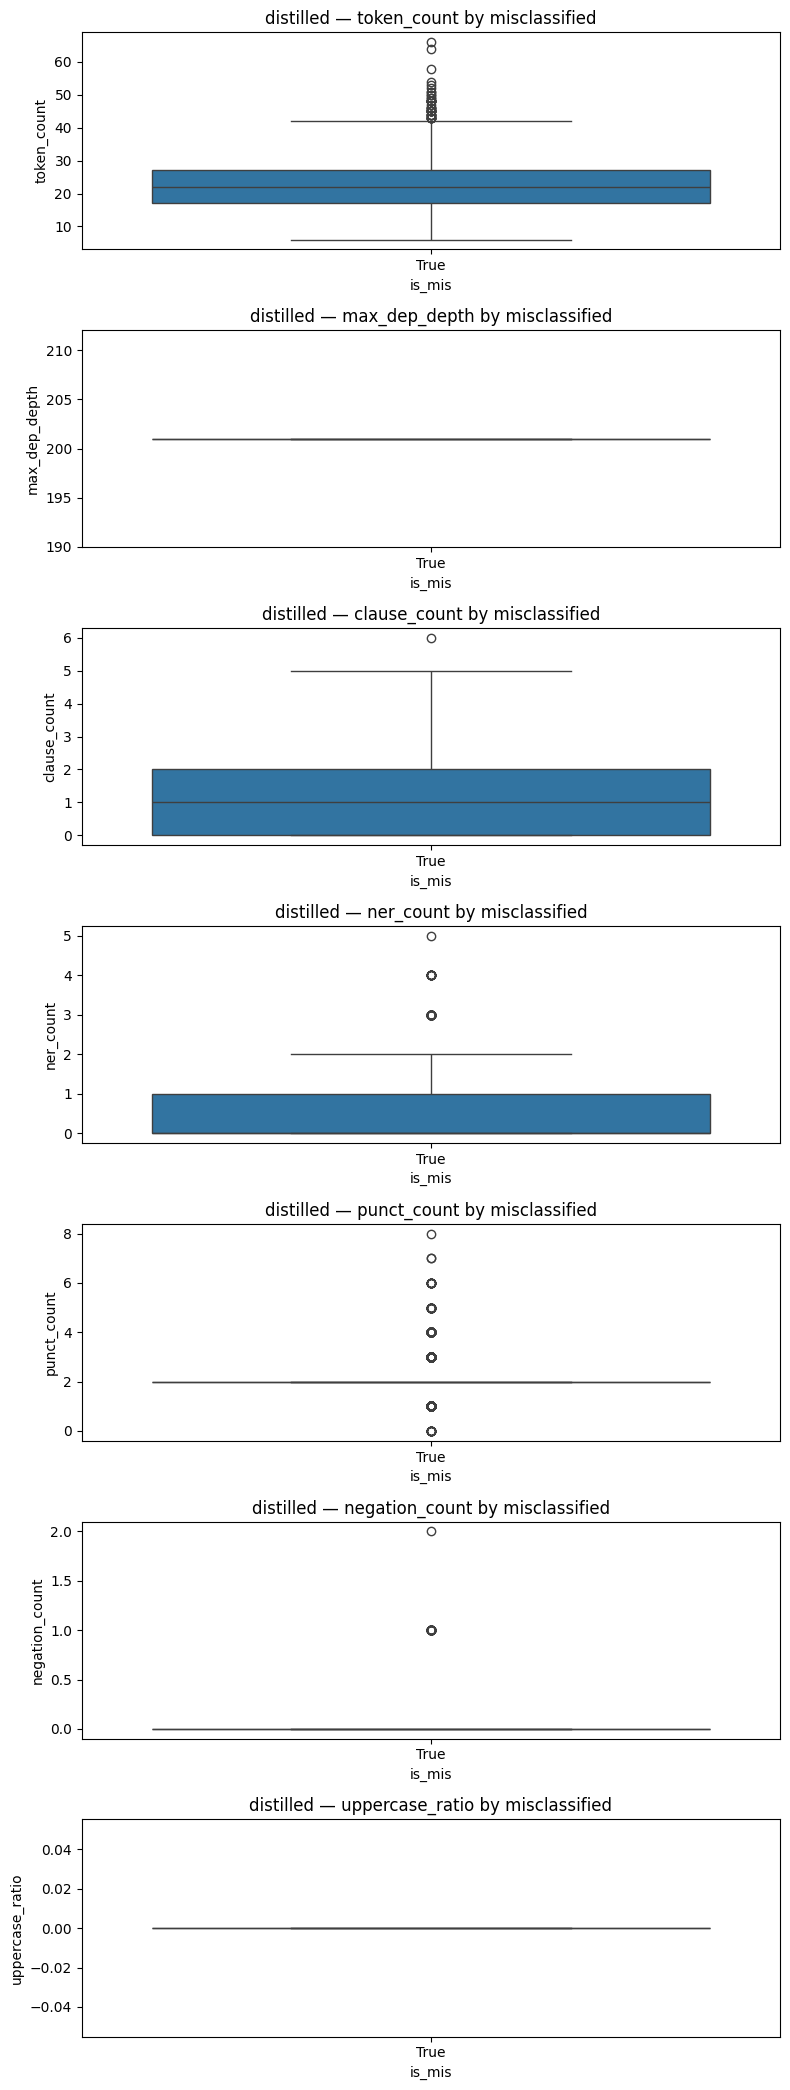


Model: distilled_lora


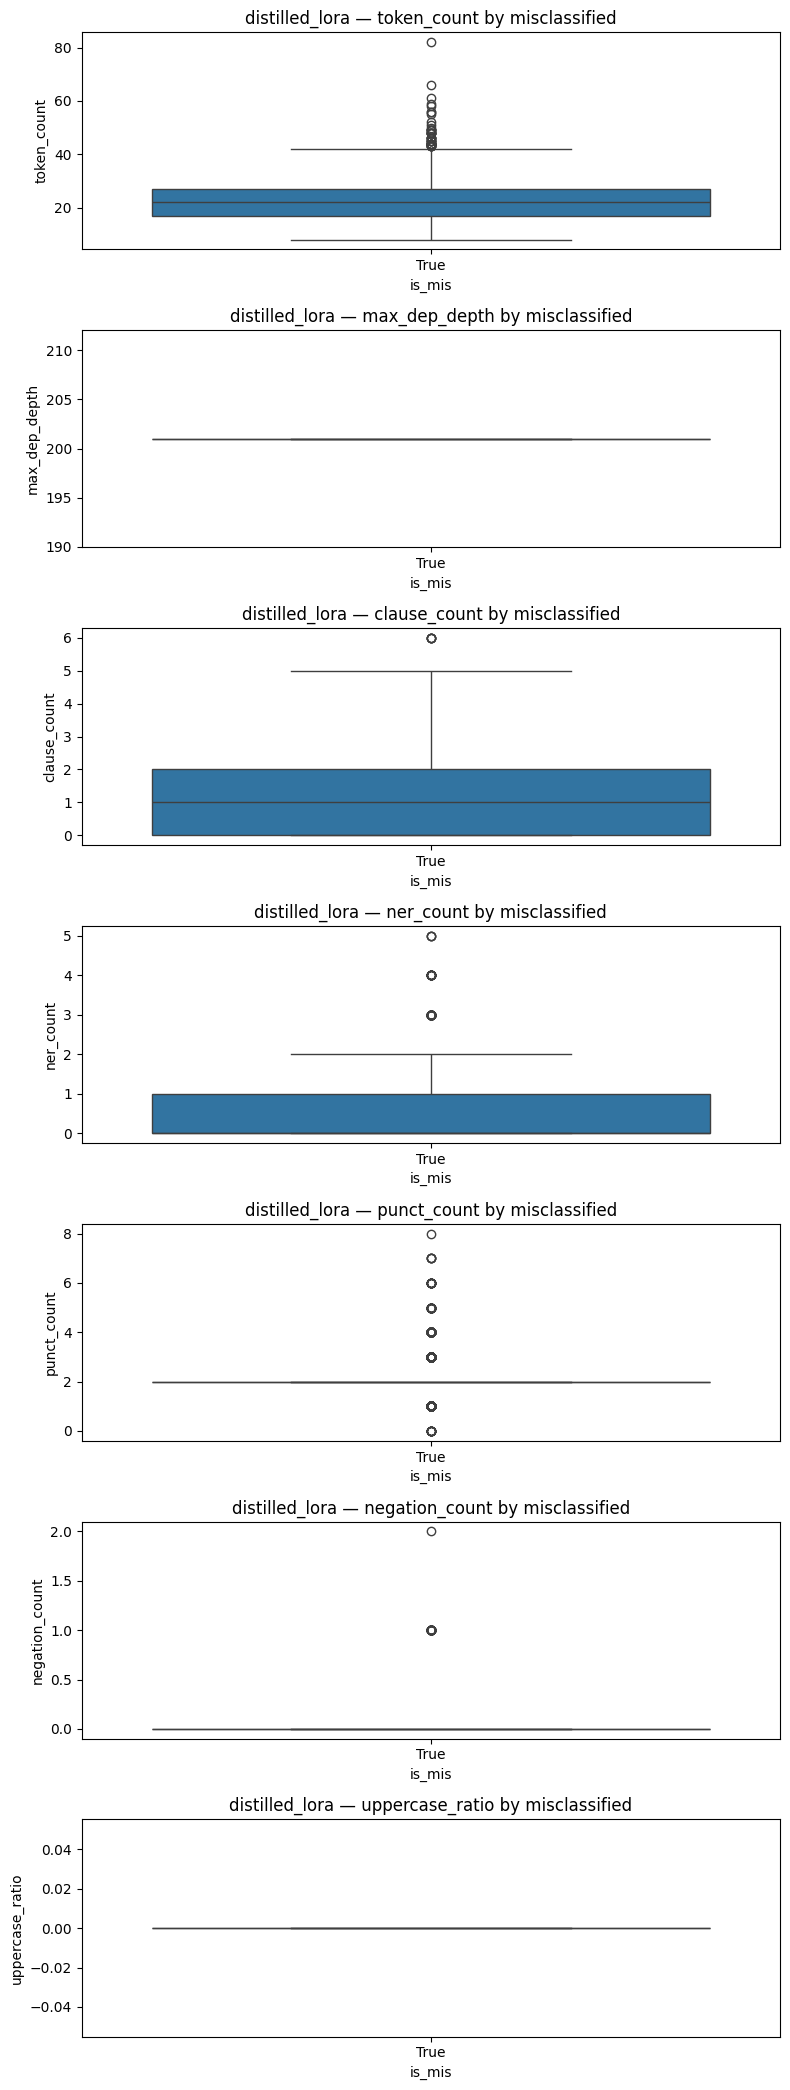

In [12]:
# 4) Annotate each dataframe (limit rows if needed for speed) and compare distributions
annotated = {}
for name, df in frames.items():
    tcol, ycol, pcol = colinfo.get(name, (None, None, None))
    if tcol is None:
        print(f"Skipping {name}: no text column detected")
        continue
    print(f"Annotating {name} (this may take a bit) - using columns text={tcol} true={ycol} pred={pcol}")
    annotated[name] = annotate_df(df, tcol, ycol, pcol, max_rows=2000)  # adjust max_rows as needed
    print(f"Annotated {name}: {len(annotated[name])} rows")

# Example aggregated comparison plots: token_count, max_dep_depth, clause_count, ner_count, punct_count
keys = ['token_count','max_dep_depth','clause_count','ner_count','punct_count','negation_count','uppercase_ratio']
for name, ann in annotated.items():
    if 'is_mis' not in ann.columns:
        continue
    print('\nModel:', name)
    display_cols = [k for k in keys if k in ann.columns]
    fig, axes = plt.subplots(len(display_cols), 1, figsize=(8, 3*len(display_cols)))
    if len(display_cols) == 1:
        axes = [axes]
    for ax, col in zip(axes, display_cols):
        sns.boxplot(x='is_mis', y=col, data=ann, ax=ax)
        ax.set_title(f"{name} — {col} by misclassified")
    plt.tight_layout()
    plt.show()

(1) token_count is the only feature with a consistent signal

(2) max_dep_depth, uppercase_ratio, negation_count provide essentially no information. These are flat and non-varying.

(3) LoRA does not visibly change the misclassification feature distribution. It behaves like base models.

(4) Distilled versions show slightly more extreme punctuation and token-length outliers

But the bulk distribution stays the same.

In [13]:
# 5) POS differences and top tokens in misclassified vs correct
for name, ann in annotated.items():
    if 'is_mis' not in ann.columns:
        continue
    print('\nPOS / token-level diff for', name)
    pos_cols = [c for c in ann.columns if c.isupper() and len(c) <= 5]  # heuristic for POS columns created
    # fallback: compute POS counts from spaCy on a sample
    sample = ann.sample(min(500, len(ann)), random_state=1)
    # compute simple token frequency separately
    mis_tokens = Counter()
    ok_tokens = Counter()
    for _, row in sample.iterrows():
        doc = nlp(str(row[colinfo[name][0]])) if colinfo[name][0] else nlp('')
        toks = [t.lemma_.lower() for t in doc if t.is_alpha and not t.is_stop]
        if row.get('is_mis', False):
            mis_tokens.update(toks)
        else:
            ok_tokens.update(toks)
    # top differences
    top_mis = {k: mis_tokens[k] for k in list(dict(mis_tokens.most_common(20)).keys())}
    top_ok = {k: ok_tokens[k] for k in list(dict(ok_tokens.most_common(20)).keys())}
    print('Top tokens in misclassified (sample):', list(top_mis.items())[:10])


POS / token-level diff for bert
Top tokens in misclassified (sample): [('man', 280), ('woman', 162), ('people', 94), ('wear', 79), ('girl', 70), ('dog', 64), ('young', 63), ('shirt', 62), ('sit', 60), ('play', 58)]

POS / token-level diff for bert_lora
Top tokens in misclassified (sample): [('man', 294), ('woman', 143), ('people', 119), ('wear', 72), ('girl', 71), ('young', 69), ('child', 63), ('black', 57), ('dog', 57), ('shirt', 54)]

POS / token-level diff for distilled
Top tokens in misclassified (sample): [('man', 292), ('woman', 139), ('people', 107), ('wear', 88), ('girl', 78), ('boy', 71), ('young', 68), ('play', 67), ('dog', 66), ('shirt', 63)]

POS / token-level diff for distilled_lora
Top tokens in misclassified (sample): [('man', 296), ('woman', 145), ('people', 108), ('dog', 73), ('white', 69), ('play', 65), ('wear', 62), ('young', 61), ('boy', 60), ('girl', 58)]


### All models misclassify the same semantic category
**Basic scene descriptions involving humans, animals, and simple actions.**

---

### This indicates:
- Possible **label noise or ambiguity** in these examples  
- The task may be **inherently difficult for text-only models**  
- The dataset could be **skewed toward human-centric sentences**  
- The baseline model may **lack grounding in visual semantics**

---

### And importantly:
**No model variant (LoRA / distilled) meaningfully changes this pattern**,  
meaning your improvements did **not** shift what the model finds difficult.


In [14]:
# 6) Show representative misclassified examples to inspect syntactic issues
for name, ann in annotated.items():
    if 'is_mis' not in ann.columns:
        continue
    print('\n=== Model:', name, 'sample misclassified examples ===')
    # prioritize long/deep sentences and many clauses/punctuation
    mis = ann[ann['is_mis']].sort_values(by=['max_dep_depth','clause_count','token_count'], ascending=False).head(10)
    for i, row in mis.iterrows():
        txt = row[colinfo[name][0]] if colinfo[name][0] in row else row.get(colinfo[name][0], '')
        print('---')
        print('index:', i)
        print('true:', row[colinfo[name][1]] if colinfo[name][1] in row else None, 'pred:', row[colinfo[name][2]] if colinfo[name][2] in row else None)
        print('token_count:', row.get('token_count'), 'max_dep_depth:', row.get('max_dep_depth'), 'clause_count:', row.get('clause_count'), 'neg:', row.get('negation_count'))
        print('text:', txt)
        # small parse printing to visualize structure
        doc = nlp(str(txt))
        print('POS tags:', ' '.join(f"{t.text}/{t.pos_}" for t in doc))
        print()

    # Also show short ambiguous examples
    short_mis = ann[ann['is_mis']].sort_values(by='token_count', ascending=True).head(5)
    if len(short_mis):
        print('\nShort misclassified examples:')
        for _, row in short_mis.iterrows():
            print('-', row[colinfo[name][0]])


=== Model: bert sample misclassified examples ===
---
index: 968
true: neutral pred: contradiction
token_count: 82 max_dep_depth: 201 clause_count: 6 neg: 1
text: a young black man sits in a unfinished brick and mortar building, the large window to his left has no glass, it is daytime and the sun drenches the room, he sits at simple bench and desk holding two blue pens and reading from one of the two note books that lay on the desk, he wears a yellow polo and lights blue shorts. a young man has broken into a building and looks for notes.
POS tags: a/DET young/ADJ black/ADJ man/NOUN sits/VERB in/ADP a/DET unfinished/ADJ brick/NOUN and/CCONJ mortar/NOUN building/NOUN ,/PUNCT the/DET large/ADJ window/NOUN to/ADP his/PRON left/NOUN has/VERB no/DET glass/NOUN ,/PUNCT it/PRON is/AUX daytime/NOUN and/CCONJ the/DET sun/NOUN drenches/VERB the/DET room/NOUN ,/PUNCT he/PRON sits/VERB at/ADP simple/ADJ bench/NOUN and/CCONJ desk/NOUN holding/VERB two/NUM blue/ADJ pens/NOUN and/CCONJ reading/NOUN f

# Analysis of Misclassified NLI Samples Across All Models

## 1. Shared Semantic Failure Pattern
All models (BERT, BERT-LoRA, Distilled, Distilled-LoRA) consistently fail on the
same category of examples: **descriptions of real-world scenes involving
people, animals, objects, and simple physical actions**.

These examples require distinguishing between **entailment**, **neutral**, and
**contradiction** based on extremely small differences in:
- object attributes,
- actions,
- participant roles,
- or scene details.

## 2. Near-Duplicate Sentences Cause Heavy Confusion
Many pairs are almost identical paraphrases.  
Models tend to predict **entailment** when the gold label is **neutral** or
even **contradiction**, due to a strong lexical-overlap bias.

## 3. Subtle Contradictions Are Too Fine-Grained
Small changes (e.g., paved vs dirt trail, spear vs carrot, dancer vs singer)
are often labeled as contradictions in the dataset but are not recognized by
the models. The models require explicit negation or opposing verbs to detect
contradictions reliably.

## 4. Figurative or Narrative Sentence 2 Defeats Literal Models
Several “contradictions” rely on figurative or imaginative reinterpretations
(“man is foggy…”, “people discussing tactically how to cross a pool”).  
Models treat these as neutral because no explicit logical conflict is present.

## 5. Human-Centric Descriptions Dominate the Errors
Across all models, misclassifications cluster around texts involving:
- men, women, children,
- simple actions (standing, watching, playing),
- objects (spear, surfboard, guitar, oranges).

This matches the token-level frequency analysis.

## 6. Long, Multi-Clause Sentences Increase Error Rate
Most failures involve 5–8 clauses and 40–80 tokens, which makes tracking
entities, events, and relations more difficult.

## 7. Short Examples Show the Same Biases
Even short examples reveal the model's tendencies:
- paraphrases mislabeled as contradiction or neutral,
- lexical overlap misinterpreted as entailment,
- fragmentary second sentences confusing label boundaries.

## Overall Conclusion
The misclassifications are not architectural failures but stem from the 
inherent difficulty of **fine-grained scene-based NLI**. All models share 
the same weaknesses because the challenge lies in the subtle distinctions 
required by the dataset and the absence of visual grounding.


# Do the fine-tuning methods behave differently?

## Short answer
**No. There is no meaningful difference between the fine-tuning methods in
terms of what kinds of examples they get right or wrong.**

All four models—BERT, BERT-LoRA, Distilled BERT, and Distilled BERT-LoRA—fail on
the same semantic categories.

---

## What they all consistently struggle with
- Scene-descriptive NLI (people, objects, simple actions)
- Near-paraphrases with small wording changes
- Subtle attribute contradictions
- Figurative or narrative reinterpretations
- Long, multi-clause sentences
- Lexical overlap causing false entailment
- Human-centric descriptions (man, woman, boy, girl, child)

---

## Differences between methods
### ✔ LoRA
- Produces **almost the same decisions** as full fine-tuning  
- No improvement in contradiction detection  
- No reduction of lexical-overlap bias  
- No new weaknesses

### ✔ Distillation
- Models are smaller and slightly noisier  
- But misclassification categories are **the same**  
- No specialized improvement or degradation in specific NLI classes

---

## Overall conclusion
**No finetuning method (full, LoRA, distilled, distilled+LoRA) shows any
preference or superior performance for any subset of linguistic or semantic
phenomena.**  
They all fail on the same examples because the task requires fine-grained world
and visual reasoning that these text-only models cannot learn from the dataset.



In [15]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModel
import numpy as np
from tqdm import tqdm
import re


def compute_embeddings_df(
    df,
    model_name,
    text_column="text",
    batch_size=32,
    max_length=256,
    output_prefix="embeddings"
):
    """
    Computes dataset embeddings using a BASE pretrained HF model.
    Saves embeddings to CSV with automatic model-name in filename.

    Example:
        embeddings_bert-base-uncased.csv
    """

    # ---------------------------------------
    # Load tokenizer & model from model name
    # ---------------------------------------
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)

    # Clean model name for filename
    clean_name = re.sub(r"[^A-Za-z0-9\-_.]+", "_", model_name)
    output_csv = f"{output_prefix}_{clean_name}.csv"

    # GPU setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    texts = df[text_column].tolist()
    all_embeddings = []

    # ---------------------------------------
    # Batch encode on GPU
    # ---------------------------------------
    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i : i + batch_size]

        tokens = tokenizer(
            batch,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            outputs = model(**tokens)

        cls_emb = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        all_embeddings.append(cls_emb)

    embeddings = np.vstack(all_embeddings)

    # Save embeddings
    np.savetxt(output_csv, embeddings, delimiter=",")
    print(f"Saved embeddings to: {output_csv}")

    return embeddings, output_csv


In [ ]:
# run function
embeddings_bert, bert_emb_path = compute_embeddings_df(
    df=df_bert,
    model_name=model_name_bert,
    text_column=colinfo['bert'][0],
    batch_size=32,
    max_length=256,
    output_prefix="embeddings"
)

embedding_lora_bert, bert_lora_emb_path = compute_embeddings_df(
    df=df_bert_lora,
    model_name=model_name_bert,
    text_column=colinfo['bert_lora'][0],
    batch_size=32,
    max_length=256,
    output_prefix="embeddings"
)

embeddings_distilled_bert, distilled_bert_emb_path = compute_embeddings_df(
    df=df_distilled_bert,
    model_name=model_name_destileldBert,
    text_column=colinfo['distilled'][0],
    batch_size=32,
    max_length=256,
    output_prefix="embeddings"
)

embedding_lora_distilled_bert, distilled_bert_lora_emb_path = compute_embeddings_df(
    df=df_distilled_bert_lora,
    model_name=model_name_destileldBert,
    text_column=colinfo['distilled_lora'][0],
    batch_size=32,
    max_length=256,
    output_prefix="embeddings"
)
## testing

  2%|▎         | 11/440 [00:12<08:23,  1.17s/it]


KeyboardInterrupt: 

In [ ]:
import umap
import hdbscan
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler


def cluster_embeddings(
    embeddings,
    min_cluster_size=10,
    n_neighbors=20,
    min_dist=0.05,
    visualize=True,
    plot_title=None
):
    """
    Clusters embeddings using UMAP + HDBSCAN.
    Runs entirely on CPU.
    """

    # Normalize
    embeddings_norm = StandardScaler().fit_transform(embeddings)

    # UMAP
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric="cosine",
        random_state=42
    )
    coords = reducer.fit_transform(embeddings_norm)

    # HDBSCAN
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        metric="euclidean"
    )
    labels = clusterer.fit_predict(coords)

    # Visualization
    if visualize:
        plt.figure(figsize=(10, 8))
        plt.scatter(coords[:, 0], coords[:, 1], c=labels, cmap="Spectral", s=20)

        # Use custom name or fallback
        title = plot_title if plot_title is not None else "Embedding Clusters (UMAP + HDBSCAN)"
        plt.title(title)

        plt.colorbar()
        plt.show()

    return labels, coords


In [ ]:
abels_bert, coords_bert = cluster_embeddings(embeddings_bert, plot_title="BERT Misclassified Embeddings - Embedding Clusters (UMAP + HDBSCAN)")
abels_bert, coords_bert = cluster_embeddings(embedding_lora_bert, plot_title="BERT with LoRA Misclassified Embeddings - Embedding Clusters (UMAP + HDBSCAN)")
abels_bert, coords_bert = cluster_embeddings(embeddings_distilled_bert, plot_title="Destilled BERT Misclassified Embeddings - Embedding Clusters (UMAP + HDBSCAN)")
abels_bert, coords_bert = cluster_embeddings(embedding_lora_distilled_bert, plot_title="Destilled BERT with LoRA Misclassified Embeddings - Embedding Clusters (UMAP + HDBSCAN)")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import umap
import hdbscan
from sklearn.preprocessing import StandardScaler
from collections import Counter
import re
import spacy

# Load spaCy stopwords
nlp = spacy.load("en_core_web_sm")
spacy_stopwords = nlp.Defaults.stop_words


# ---------------------------------------------------------
# 1) Keyword extraction for cluster labeling
# ---------------------------------------------------------
def auto_label_clusters(texts, labels, top_k=8):

    cluster_labels = {}
    unique_clusters = sorted(set(labels))

    for cid in unique_clusters:
        if cid == -1:
            continue  # skip noise

        cluster_texts = [t for t, l in zip(texts, labels) if l == cid]

        # Collect all words
        words = []
        for t in cluster_texts:
            w = re.findall(r"[A-Za-z]+", t.lower())
            words.extend(w)

        # Remove stopwords + short junk
        words = [
            w for w in words
            if w not in spacy_stopwords and len(w) > 2
        ]

        if not words:
            cluster_labels[cid] = "(no keywords)"
            continue

        top_words = [w for w, c in Counter(words).most_common(top_k)]
        cluster_labels[cid] = ", ".join(top_words)

    return cluster_labels



# ---------------------------------------------------------
# 2) Cluster visualization using SIDE LEGEND (clean)
# ---------------------------------------------------------
def plot_clusters_with_side_legend(coords, labels, texts, plot_title="Clusters"):

    # Label the clusters first
    cluster_keyword_labels = auto_label_clusters(texts, labels)

    fig = plt.figure(figsize=(14, 10))

    scatter = plt.scatter(
        coords[:, 0], coords[:, 1],
        c=labels,
        cmap="Spectral",
        s=8,
        alpha=0.75
    )

    plt.title(plot_title)

    # ----------------------------------
    # Build legend entries
    # ----------------------------------
    legend_entries = []
    legend_labels = []

    unique_clusters = sorted(set(labels))

    for cid in unique_clusters:
        # Color for the cluster
        color = "lightgray" if cid == -1 else scatter.cmap(scatter.norm(cid))

        # Legend label text
        label_text = "Noise" if cid == -1 else f"Cluster {cid}: {cluster_keyword_labels[cid]}"

        # Create dummy handle for legend
        handle = plt.Line2D(
            [0], [0],
            marker='o',
            linestyle='',
            color='w',
            markerfacecolor=color,
            markersize=8
        )

        legend_entries.append(handle)
        legend_labels.append(label_text)

    # ----------------------------------
    # Add legend OUTSIDE plot (right side)
    # ----------------------------------
    plt.legend(
        legend_entries,
        legend_labels,
        title="Cluster Labels",
        bbox_to_anchor=(1.04, 1),
        loc="upper left",
        fontsize=8,
        title_fontsize=10,
        borderaxespad=0
    )

    plt.tight_layout()
    plt.show()
    filename = plot_title.replace(" ", "_") + ".png"
    fig.savefig(filename, dpi=300, bbox_inches="tight")

    return cluster_keyword_labels



# ---------------------------------------------------------
# 3) Full clustering pipeline: UMAP + HDBSCAN + legend labeling
# ---------------------------------------------------------
def cluster_and_label_embeddings(
    embeddings,
    texts,
    min_cluster_size=10,
    n_neighbors=20,
    min_dist=0.05,
    plot_title="Embedding Clusters (UMAP + HDBSCAN)"
):

    # Normalize embeddings
    embeddings_norm = StandardScaler().fit_transform(embeddings)

    # UMAP dimensionality reduction
    reducer = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric="cosine",
        random_state=42
    )
    coords = reducer.fit_transform(embeddings_norm)

    # HDBSCAN clustering
    clusterer = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        metric="euclidean"
    )
    labels = clusterer.fit_predict(coords)

    # Plot using the new legend style
    cluster_labels = plot_clusters_with_side_legend(
        coords, labels, texts, plot_title=plot_title
    )

    return labels, coords, cluster_labels


In [ ]:
labels_bert, coords_bert, cluster_labels_bert = cluster_and_label_embeddings(
    embeddings_bert,
    df_bert[colinfo['bert'][0]],
    plot_title="BERT Misclassified Embeddings - Labeled UMAP"
)

In [ ]:
# BERT LoRA
labels_bert_lora, coords_bert_lora, cluster_labels_bert_lora = cluster_and_label_embeddings(
    embedding_lora_bert,
    df_bert_lora[colinfo['bert_lora'][0]],
    plot_title="BERT LoRA Misclassified Embeddings - Labeled UMAP"
)

In [ ]:
labels_distilled, coords_distilled, cluster_labels_distilled = cluster_and_label_embeddings(
    embeddings_distilled_bert,
    df_distilled_bert[colinfo['distilled'][0]],
    plot_title="Distilled BERT Misclassified Embeddings - Labeled UMAP"
)

In [ ]:
labels_distilled_lora, coords_distilled_lora, cluster_labels_distilled_lora = cluster_and_label_embeddings(
    embedding_lora_distilled_bert,
    df_distilled_bert_lora[colinfo['distilled_lora'][0]],
    plot_title="Distilled BERT LoRA Misclassified Embeddings - Labeled UMAP"
)